In [1]:
#导入库和配置超参数
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数
batch_size = 32
num_epochs = 10
learning_rate = 0.001
num_classes = 3  # 猫、狗、蝴蝶三个类别

In [4]:
# 数据集路径
train_dir = r"D:\dataset\train"
val_dir = r"D:\dataset\val"

# 数据增强和预处理
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 调整图像大小
    transforms.ToTensor(),  # 转为张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 加载数据
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 打印类别映射
print("Class to Index Mapping:", train_dataset.class_to_idx)

Class to Index Mapping: {'deer': 0, 'dog': 1, 'duck': 2}


In [5]:
#CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 输入通道数为3 (RGB)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),  # 假设输入图像大小为128x128
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = SimpleCNN(num_classes=num_classes).to(device)

In [6]:
#定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# 训练函数
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")
    return train_losses

# 验证函数
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    return accuracy

              precision    recall  f1-score   support

        deer       0.33      1.00      0.50        24
         dog       0.00      0.00      0.00        24
        duck       0.00      0.00      0.00        24

    accuracy                           0.33        72
   macro avg       0.11      0.33      0.17        72
weighted avg       0.11      0.33      0.17        72



C:\Users\46655\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\46655\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\46655\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


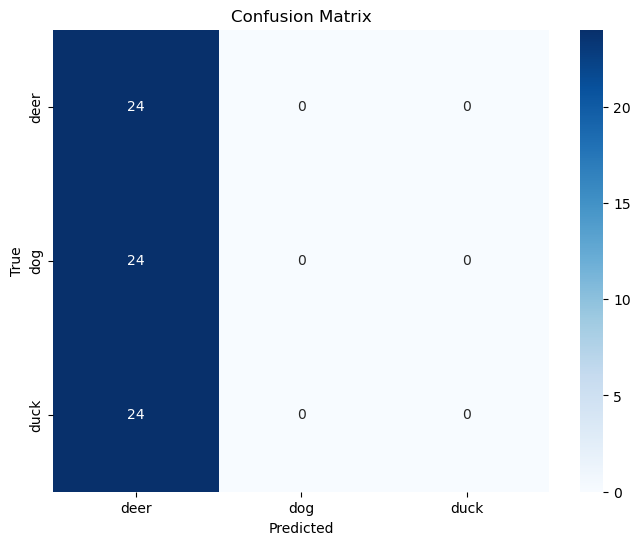

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 计算并打印评估指标
def evaluate_model_detailed(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # 分类报告
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
    
    # 混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
# 调用新的评估函数
evaluate_model_detailed(model, val_loader)

Epoch [1/10], Loss: 1.1902
Epoch [2/10], Loss: 1.0947
Epoch [3/10], Loss: 1.0408
Epoch [4/10], Loss: 0.9725
Epoch [5/10], Loss: 0.9120
Epoch [6/10], Loss: 0.7467
Epoch [7/10], Loss: 0.6804
Epoch [8/10], Loss: 0.5249
Epoch [9/10], Loss: 0.4902
Epoch [10/10], Loss: 0.3483
Validation Accuracy: 58.33%


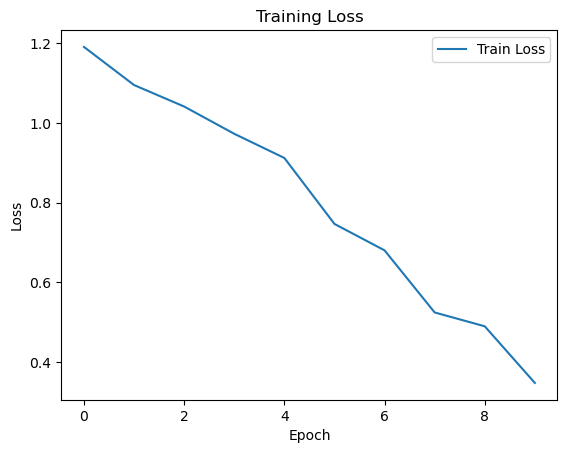

In [9]:
# 训练和验证
train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs)
val_accuracy = evaluate_model(model, val_loader)

# 可视化训练损失
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [ ]:
# 保存模型
torch.save(model.state_dict(), "cat_dog_cow_cnn.pth")

# 加载模型
model.load_state_dict(torch.load("cat_dog_cow_cnn.pth"))
model.eval()